In [370]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas
import holoviews as hv
from scipy import stats
import scipy
import shutil
import joblib

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Concatenate, Permute, Multiply, Reshape

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor

from joblib import dump, load, parallel_backend, Parallel, delayed


from tensorflow.keras.utils import to_categorical, plot_model
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.layers import Dropout
from keras.models import load_model
from keras_tuner import RandomSearch
from keras.callbacks import EarlyStopping
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1, l2, l1_l2
from tensorflow.keras import layers

from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError

from keras_tuner import RandomSearch
from keras_tuner import BayesianOptimization
from keras_tuner import Hyperband
import keras_tuner as kt

In [289]:
# read in the imputed dataframes as combined_survey
combined_survey = pd.read_csv('Resources/survey_imputed/2010_imputed.csv')
for year in range(2011, 2023):
    df = pd.read_csv(f'Resources/survey_imputed/{year}_imputed.csv')
    combined_survey = pd.concat([combined_survey, df], ignore_index=True)

combined_survey.head()

,year,agency,my_work_experience,my_work_unit,my_organization,my_supervisor,leadership,my_satisfaction,employee_experience,circumstantial,DEIA,negativity_index
0,2010,AF,2.894737,3.111111,0.0,0.0,0.0,0.0,0.000000,0.0,3.506584,0.0
1,2010,AF,4.052632,2.555556,0.0,0.0,0.0,0.0,0.000000,0.0,3.482190,0.0
2,2010,AF,3.526316,3.000000,3.0,3.9,3.5,3.0,4.066667,0.0,3.253816,4.0
3,2010,AF,5.000000,4.222222,0.0,0.0,0.0,0.0,0.000000,0.0,3.448078,0.0
4,2010,AF,3.684211,3.444444,0.0,0.0,0.0,0.0,0.000000,0.0,3.432955,0.0


In [290]:
def describe_stats_by_agency_and_year(df, features, year_column='year', agency_column='agency'):
    """
    Generate descriptive statistics for specified features grouped by agency and year in a DataFrame.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - features (list): A list of feature column names for which descriptive statistics are to be generated.
    - agency_column (str, optional): The name of the column representing agencies. Default is 'agency'.
    - year_column (str, optional): The name of the column representing years. Default is 'year'.

    Returns:
    - pd.DataFrame: Descriptive statistics for the specified features grouped by agency and year.
    """
    # Check if the agency and year columns exist in the DataFrame
    if agency_column not in df.columns or year_column not in df.columns:
        return f"Error: Columns '{agency_column}' or '{year_column}' not found in the DataFrame."

    # Check if all specified features exist in the DataFrame
    missing_features = set(features) - set(df.columns)
    if missing_features:
        return f"Error: Columns {missing_features} not found in the DataFrame."


    # Iterate through each feature and calculate descriptive statistics

    stats_by_agency_and_year = df.groupby([year_column, agency_column]).describe()
    # Remove 'min' and 'max' columns

    return stats_by_agency_and_year

# Example usage:
# Assuming 'df' is your DataFrame
# and 'feature_columns' is a list of feature column names for which you want descriptive statistics
df = combined_survey.copy()
feature_columns = ['my_work_experience', 'my_work_unit', 'my_organization', 'my_supervisor', 'leadership', 'my_satisfaction', 'employee_experience', 'circumstantial', 'DEIA', 'negativity_index']
result = describe_stats_by_agency_and_year(df, feature_columns)

# Round the result to 2 decimals
rounded_stats = round(result, 2)
# rename level 1 columns with 25%, 50%, 75% to Q1, Q2, Q3
rounded_stats.rename(columns={'25%': 'Q1', '50%': 'Q2', '75%': 'Q3'}, inplace=True)
# rename the level 1 columns as level 0 _ level 1
rounded_stats.columns = rounded_stats.columns.map('_'.join)

# reset the index
rounded_stats.reset_index(inplace=True)

rounded_stats.head()


,year,agency,my_work_experience_count,my_work_experience_mean,my_work_experience_std,my_work_experience_min,my_work_experience_Q1,my_work_experience_Q2,my_work_experience_Q3,my_work_experience_max,...,DEIA_Q3,DEIA_max,negativity_index_count,negativity_index_mean,negativity_index_std,negativity_index_min,negativity_index_Q1,negativity_index_Q2,negativity_index_Q3,negativity_index_max
0,2010,AF,10560.0,3.89,0.64,0.0,3.53,3.95,4.32,5.0,...,4.16,4.99,10560.0,4.16,1.15,0.0,3.67,4.33,5.0,5.0
1,2010,AR,19413.0,3.88,0.63,0.0,3.53,3.95,4.32,5.0,...,4.16,4.98,19413.0,4.10,1.15,0.0,3.67,4.33,5.0,5.0
2,2010,NV,12378.0,3.86,0.62,0.0,3.47,3.89,4.26,5.0,...,4.14,5.00,12378.0,4.17,1.17,0.0,3.67,4.33,5.0,5.0
3,2011,AF,8775.0,3.87,0.65,0.0,3.47,3.89,4.32,5.0,...,4.10,4.96,8775.0,4.06,1.31,0.0,3.67,4.33,5.0,5.0
4,2011,AR,18827.0,3.89,0.63,0.0,3.53,3.95,4.32,5.0,...,4.11,4.95,18827.0,4.08,1.21,0.0,3.67,4.33,5.0,5.0


In [291]:
#read in all end strength csvs and combine into one dataframe 2008-2023
end_strength_2008 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_200809.csv')
end_strength_2009 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_200909.csv')
end_strength_2010 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_201009.csv')
end_strength_2011 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_201109.csv')
end_strength_2012 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_201209.csv')
end_strength_2013 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_201309.csv')
end_strength_2014 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_201409.csv')
end_strength_2015 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_201509.csv')
end_strength_2016 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_201609.csv')
end_strength_2017 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_201709.csv')
end_strength_2018 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_201809.csv')
end_strength_2019 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_201909.csv')
end_strength_2020 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_202009.csv')
end_strength_2021 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_202109.csv')
end_strength_2022 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_202209.csv')
end_strength_2023 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_202309.csv')

# add a Space Force column to each dataframe before 2023
for year in range(2008, 2023):
    eval(f'end_strength_{year}')['Space Force'] = 0

#rename the 2nd column to Rank
for year in range(2008, 2024):
    eval(f'end_strength_{year}').rename(columns={eval(f'end_strength_{year}').columns[1]: 'Rank'}, inplace=True)



# replace rank values with O10, O9, O8, O7, O6, O5, O4, O3, O2, O1, W5, W4, W3, W2, W1, E9, E8, E7, E6, E5, E4, E3, E2, E1
# O11 coincides with the first row of the dataframe, O10 with the second, etc.

for year in range(2008, 2024):
    ranks = ['O10', 'O9', 'O8', 'O7', 'O6', 'O5', 'O4', 'O3', 'O2', 'O1', 'W5', 'W4', 'W3', 'W2', 'W1', 'E9', 'E8', 'E7', 'E6', 'E5', 'E4', 'E3', 'E2', 'E1']
    for i in range(len(ranks)):
        eval(f'end_strength_{year}').loc[i, 'Rank'] = ranks[i]


# create internal loop to rename the columns for each year
for year in range(2008, 2024):
    dataframe_name = f'end_strength_{year}'
    df = globals()[dataframe_name]
    # convert the cuears}'rrent year column names to Army: AR, Navy: NV, Air Force: AF, Space Force: AF, Marine Corps: MC
    df.rename(columns={'Army': 'AR', 'Navy': 'NV', 'Air Force': 'AF', 'Space Force': 'SF', 'Marine Corps': 'MC'}, inplace=True)

    # sum the values of the Navy and Marine Corps columns and rewrite the values in the Navy column
    df['NV'] = df['NV'] + df['MC']
    # drop the Marine Corps column
    df.drop(columns='MC', inplace=True)
    #drop the Space Force column
    df.drop(columns='SF', inplace=True)

    # rename Year to year
    df.rename(columns={'Year': 'year'}, inplace=True)

    # split each dataframe into service data frames per year
    df_AR = df[['year', 'Rank', 'AR']]
    df_NV = df[['year', 'Rank', 'NV']]
    df_AF = df[['year', 'Rank', 'AF']]

    #export each dataframe to a csv as year_service.csv
    df_AR.to_csv(f'Resources/end_strength/service_by_year/{year}_AR.csv', index=False)
    df_NV.to_csv(f'Resources/end_strength/service_by_year/{year}_NV.csv', index=False)
    df_AF.to_csv(f'Resources/end_strength/service_by_year/{year}_AF.csv', index=False)

    globals()[dataframe_name] = df

for service in ['AR', 'NV', 'AF']:    
    for year in range(2010, 2023):


        # Construct the variable name for the dataframe
        dataframe_service_current = pd.read_csv(f'Resources/end_strength/service_by_year/{year}_{service}.csv')
        dataframe_service_previous = pd.read_csv(f'Resources/end_strength/service_by_year/{year - 1}_{service}.csv')
        dataframe_service_previous2 = pd.read_csv(f'Resources/end_strength/service_by_year/{year - 2}_{service}.csv')
        dataframe_service_next = pd.read_csv(f'Resources/end_strength/service_by_year/{year + 1}_{service}.csv')

        dataframe_service_current['minus_1'] = dataframe_service_previous[f'{service}']
        dataframe_service_current['minus_2'] = dataframe_service_previous2[f'{service}']
        dataframe_service_current['plus_1'] = dataframe_service_next[f'{service}']

        dataframe_service_current['minus_1'] = dataframe_service_current[f'{service}'] - dataframe_service_current['minus_1']
        dataframe_service_current['minus_2'] = dataframe_service_current[f'{service}'] - dataframe_service_current['minus_2']
        dataframe_service_current['plus_1'] = dataframe_service_current['plus_1'] - dataframe_service_current[f'{service}']

        #if plus_1 is negative, make it 0 to indicate a decrease in end strength, otherwise make it 1 to indicate an increase
        dataframe_service_current['slope'] = np.where(dataframe_service_current['plus_1'] < 0, 0, 1)

        dataframe_service_current.rename(columns={f'{service}': 'current'}, inplace=True)

        dataframe_service_current['agency'] = service

        column_order = ['year', 'agency', 'Rank', 'minus_2', 'minus_1', 'current', 'plus_1', 'slope']
        dataframe_service_current = dataframe_service_current[column_order]

        #export each dataframe to a csv as year_service_comparison.csv
        dataframe_service_current.to_csv(f'Resources/end_strength/service_by_year/{year}_{service}_comparison.csv', index=False)

# Create master dataframe for end strength
end_strength = pd.DataFrame(columns=['year', 'agency', 'Rank', 'minus_2', 'minus_1', 'current', 'plus_1', 'slope'])

for service in ['AR', 'NV', 'AF']:
    for year in range(2010, 2023):
        dataframe_service_current = pd.read_csv(f'Resources/end_strength/service_by_year/{year}_{service}_comparison.csv')
        end_strength = pd.concat([end_strength, dataframe_service_current], ignore_index=True)
    
    #delete the year_service.csv files
    for year in range(2008, 2024):
        os.remove(f'Resources/end_strength/service_by_year/{year}_{service}.csv')

end_strength.to_csv('Resources/end_strength/end_strength_combined.csv', index=False)
    

# print test dataframe
print(pd.read_csv('Resources/end_strength/service_by_year/2022_AR_comparison.csv').head(25))









    year agency Rank  minus_2  minus_1  current  plus_1  slope
0   2022     AR  O10       -1        0       16      -1      0
1   2022     AR   O9       -1       -2       46      -2      0
2   2022     AR   O8       15        3      108     -13      0
3   2022     AR   O7      -20      -11      118      -5      0
4   2022     AR   O6     -235     -136     3767    -113      0
5   2022     AR   O5     -127     -237     8902    -207      0
6   2022     AR   O4       74      -48    16131    -164      0
7   2022     AR   O3       68      -15    27212    -457      0
8   2022     AR   O2      -55      -77    12209      93      1
9   2022     AR   O1      261      374    10111    -628      0
10  2022     AR   W5       20       28      571     -14      0
11  2022     AR   W4     -101     -124     1848     -94      0
12  2022     AR   W3     -301     -136     3339    -177      0
13  2022     AR   W2      413       91     5940     -31      0
14  2022     AR   W1      669      508     3343     722

In [292]:
# combine all of the end strength dataframes into one dataframe
all_end_strength = end_strength.copy()

all_end_strength.head()

,year,agency,Rank,minus_2,minus_1,current,plus_1,slope
0,2010,AR,O10,0,1,12,0,1
1,2010,AR,O9,-5,-3,49,1,1
2,2010,AR,O8,16,2,100,8,1
3,2010,AR,O7,-11,-11,157,-13,0
4,2010,AR,O6,101,-3,4356,78,1


In [293]:
print(end_strength.shape)
print(end_strength.head())

(936, 8)
   year agency Rank minus_2 minus_1 current plus_1 slope
0  2010     AR  O10       0       1      12      0     1
1  2010     AR   O9      -5      -3      49      1     1
2  2010     AR   O8      16       2     100      8     1
3  2010     AR   O7     -11     -11     157    -13     0
4  2010     AR   O6     101      -3    4356     78     1


Logistic Regression Model

In [294]:
# Initial imports
import pandas as pd
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [295]:
# Define features set
regression_df = all_end_strength[all_end_strength['year'] != 2022].copy()
regression_df.drop(columns=['year', 'plus_1'], inplace=True)
regression_df.head()


,agency,Rank,minus_2,minus_1,current,slope
0,AR,O10,0,1,12,1
1,AR,O9,-5,-3,49,1
2,AR,O8,16,2,100,1
3,AR,O7,-11,-11,157,0
4,AR,O6,101,-3,4356,1


In [296]:
regression_df.tail()

,agency,Rank,minus_2,minus_1,current,slope
907,AF,E5,56,94,61600,0
908,AF,E4,6513,3602,61063,1
909,AF,E3,-6745,-5040,48421,0
910,AF,E2,575,247,8143,0
911,AF,E1,-2704,128,8266,1


In [297]:
all_columns = set(regression_df.columns)
categorical_columns = {'agency','Rank'} #, 'year', 'Rank'

# Define feature_columns as all columns except categorical and target columns


categorical_columns = list(categorical_columns)
feature_columns = list(set(all_columns) - set(categorical_columns) - set(['slope']))


In [298]:
# split into X and Y
X = regression_df.drop(columns='slope')
y = regression_df['slope']
# set y data type to integer
y = y.astype(int)

X.head()

,agency,Rank,minus_2,minus_1,current
0,AR,O10,0,1,12
1,AR,O9,-5,-3,49
2,AR,O8,16,2,100
3,AR,O7,-11,-11,157
4,AR,O6,101,-3,4356


In [299]:
y.head()

0    1
1    1
2    1
3    0
4    1
Name: slope, dtype: int32

In [300]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# convert categorical data to numbers
X = pd.get_dummies(X, columns=categorical_columns)
# convert target data to numbers


# Assuming X_train_scaled, y_train are your input features and target variable
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=78)


# Standardize features if needed
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_scaled)
X_test_scaled = scaler.transform(X_test_scaled)

# Create a Logistic Regression model (you can use the classifier appropriate for your task)
model = LogisticRegression(solver='lbfgs', random_state=78)

# Fit the model
model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=78)

In [301]:
#Find the accuracy of the model

from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred.round())
print(f"Accuracy: {accuracy}")

Accuracy: 0.5555555555555556


In [302]:
#Create a classification report

from sklearn.metrics import classification_report

class_report = classification_report(y_test, y_pred.round())
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.44      0.52       119
           1       0.50      0.70      0.59        97

    accuracy                           0.56       216
   macro avg       0.57      0.57      0.55       216
weighted avg       0.58      0.56      0.55       216



In [303]:
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(confusion_mat)

Confusion Matrix:
[[52 67]
 [29 68]]


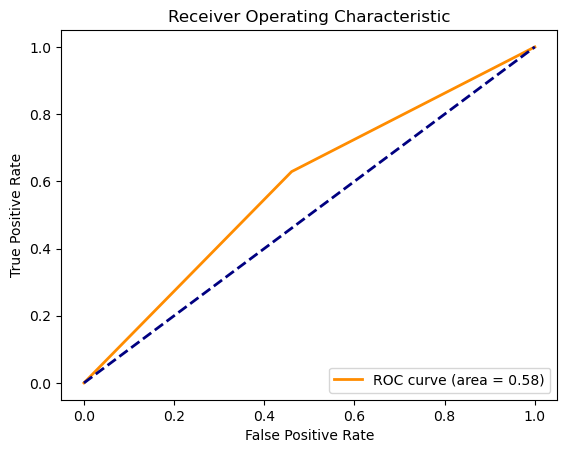

In [304]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming X_train, y_train are your input features and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a DecisionTreeClassifier model
model = DecisionTreeClassifier()

# Fit the model
model.fit(X_train, y_train)

# Get predicted probabilities for the positive class
y_prob = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [152]:
# export the model to a file
filename = 'Resources/end_strength/slope_regression_model.sav'

joblib.dump(model, filename)


['Resources/end_strength/slope_regression_model.sav']

KMeans Clustering

In [76]:
# Conduct K means clustering on the all_surveys dataframe
# Create a copy of the dataframe

df = combined_survey.copy()


df.head()

,year,agency,my_work_experience,my_work_unit,my_organization,my_supervisor,leadership,my_satisfaction,employee_experience,circumstantial,DEIA,negativity_index
0,2010,AF,2.894737,3.111111,0.0,0.0,0.0,0.0,0.000000,0.0,3.506584,0.0
1,2010,AF,4.052632,2.555556,0.0,0.0,0.0,0.0,0.000000,0.0,3.482190,0.0
2,2010,AF,3.526316,3.000000,3.0,3.9,3.5,3.0,4.066667,0.0,3.253816,4.0
3,2010,AF,5.000000,4.222222,0.0,0.0,0.0,0.0,0.000000,0.0,3.448078,0.0
4,2010,AF,3.684211,3.444444,0.0,0.0,0.0,0.0,0.000000,0.0,3.432955,0.0


In [77]:


all_columns = set(df.columns)
categorical_columns = {'agency'} #, 'year', 'Rank'

# Define feature_columns as all columns except categorical and target columns
feature_columns = list(all_columns - categorical_columns)

categorical_columns = list(categorical_columns)





#feature_columns = ['my_work_experience', 'my_work_unit', 'my_organization', 'my_supervisor', 'leadership', 'my_satisfaction', 'employee_experience', 'circumstantial', 'DEIA', 'negativity_index']
#categorical_columns = ['agency']
# Separate feature and categorical dataframes
df_feature = df[feature_columns]
df_categorical = df[categorical_columns]

# Convert categorical data to dummy variables
df_categorical = pd.get_dummies(df_categorical)

# Replace NaN values in feature dataframe with 0
df_feature = df_feature.fillna(0)

# Implement standard scaler on continuous features
scaler = StandardScaler()
scaled_df_feature = scaler.fit_transform(df_feature)

# Convert the scaled feature array back to a dataframe
scaled_df_feature = pd.DataFrame(scaled_df_feature, columns=feature_columns)

# Combine the scaled feature dataframe with the categorical dummy dataframe
final_df = pd.concat([scaled_df_feature, df_categorical], axis=1)

# Conduct PCA
pca1 = PCA(n_components=5)
pca2 = PCA(n_components=5)
pca_df_combined = pca1.fit_transform(final_df)
pca_df_feature = pca2.fit_transform(scaled_df_feature)

# Print explained variance ratio
print(f'Combined Feature and Agency variance explained:  {pca1.explained_variance_ratio_}')
print(f'Feature only variance explained: {pca2.explained_variance_ratio_}')

# Create a dataframe with the PCAs
pca_df = pd.DataFrame(pca_df_feature, columns=['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5'])




Combined Feature and Agency variance explained:  [0.46864143 0.15654419 0.09810629 0.07240797 0.03942426]
Feature only variance explained: [0.49618667 0.16544367 0.10386913 0.0766344  0.04170143]


In [78]:
pca_df.shape

(1254450, 5)

In [79]:
# Elbow curve
inertia = []
k = list(range(1, 11))

for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(pca_df)
    inertia.append(km.inertia_)

c:\Users\raymm\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\raymm\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\raymm\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\raymm\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

In [80]:
# Define a DataFrame to hold the values for k and the corresponding inertia
elbow_data = {"k": k, "inertia": inertia}

# Create the DataFrame from the elbow data
df_elbow = pd.DataFrame(elbow_data)

# Review the DataFrame
df_elbow.head()

,k,inertia
0,1,1.219600e+07
1,2,7.695547e+06
2,3,6.271811e+06
3,4,5.414266e+06
4,5,4.687614e+06


In [81]:
df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")

c:\Users\raymm\anaconda3\lib\site-packages\holoviews\core\data\pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
c:\Users\raymm\anaconda3\lib\site-packages\holoviews\core\data\pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:Curve   [k]   (inertia)

In [82]:
model = KMeans(n_clusters=5, random_state=0)

# Fit the model
model.fit(pca_df)

# Predict clusters
predictions = model.predict(pca_df)

# Add the predicted class columns
all_survey_predictions = df.copy()

all_survey_predictions["cluster"] = predictions


pca_df["cluster"] = predictions

# Review the DataFrame
all_survey_predictions.head()


c:\Users\raymm\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,year,agency,my_work_experience,my_work_unit,my_organization,my_supervisor,leadership,my_satisfaction,employee_experience,circumstantial,DEIA,negativity_index,cluster
0,2010,AF,2.894737,3.111111,0.0,0.0,0.0,0.0,0.000000,0.0,3.506584,0.0,4
1,2010,AF,4.052632,2.555556,0.0,0.0,0.0,0.0,0.000000,0.0,3.482190,0.0,4
2,2010,AF,3.526316,3.000000,3.0,3.9,3.5,3.0,4.066667,0.0,3.253816,4.0,0
3,2010,AF,5.000000,4.222222,0.0,0.0,0.0,0.0,0.000000,0.0,3.448078,0.0,4
4,2010,AF,3.684211,3.444444,0.0,0.0,0.0,0.0,0.000000,0.0,3.432955,0.0,4


In [83]:
all_survey_predictions.shape

(1254450, 13)

In [84]:
all_survey_predictions['agency'].value_counts()

agency
AR    554520
NV    390916
AF    309014
Name: count, dtype: int64

In [85]:
# provide cluster value counts
all_survey_predictions['cluster'].value_counts()

cluster
1    300481
3    299654
2    292563
0    221890
4    139862
Name: count, dtype: int64

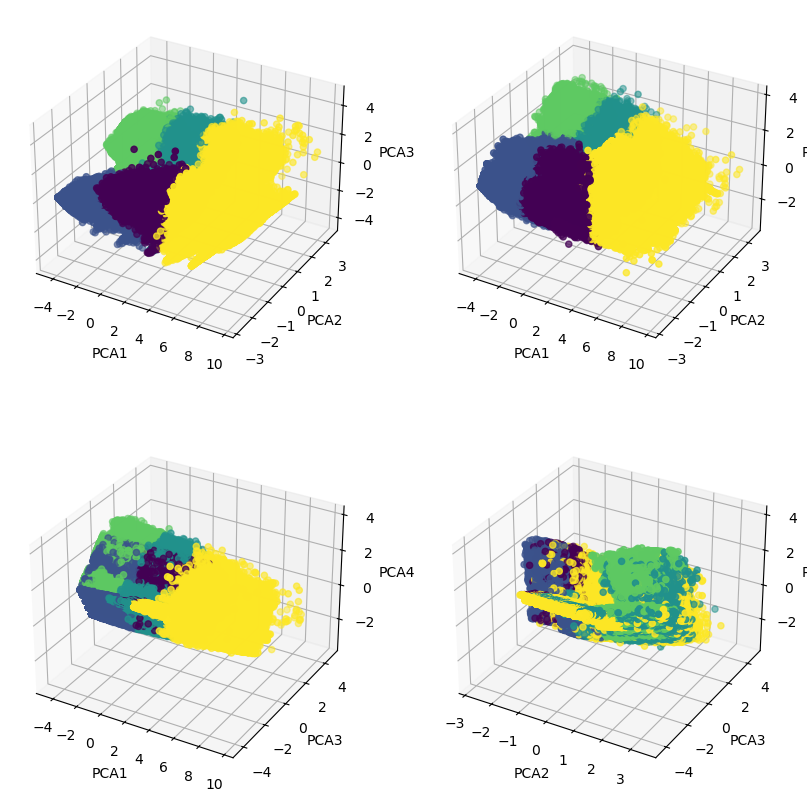

In [86]:
# plot the clusters on a 3D scatter plot
fig = plt.figure(figsize=(10, 10))

# create 4 subplots with different PCA combinations
ax1 = fig.add_subplot(221, projection='3d')
ax1.scatter(pca_df['PCA1'], pca_df['PCA2'], pca_df['PCA3'], c=pca_df['cluster'])
ax1.set_xlabel('PCA1')
ax1.set_ylabel('PCA2')
ax1.set_zlabel('PCA3')

ax2 = fig.add_subplot(222, projection='3d')
ax2.scatter(pca_df['PCA1'], pca_df['PCA2'], pca_df['PCA4'], c=pca_df['cluster'])
ax2.set_xlabel('PCA1')
ax2.set_ylabel('PCA2')
ax2.set_zlabel('PCA4')

ax3 = fig.add_subplot(223, projection='3d')
ax3.scatter(pca_df['PCA1'], pca_df['PCA3'], pca_df['PCA4'], c=pca_df['cluster'])
ax3.set_xlabel('PCA1')
ax3.set_ylabel('PCA3')
ax3.set_zlabel('PCA4')

ax4 = fig.add_subplot(224, projection='3d')
ax4.scatter(pca_df['PCA2'], pca_df['PCA3'], pca_df['PCA4'], c=pca_df['cluster'])
ax4.set_xlabel('PCA2')
ax4.set_ylabel('PCA3')
ax4.set_zlabel('PCA4')


plt.show()

In [87]:
# group by year, agency, and cluster

print(all_survey_predictions.shape)

# one hot encode the cluster column
one_hot_clusters = pd.get_dummies(all_survey_predictions, columns=['cluster'])

#drop feature columns
one_hot_clusters.drop(columns=feature_columns, inplace=True)

# add the year column back in
one_hot_clusters['year'] = all_survey_predictions['year']

# Original Option
grouped_clusters = one_hot_clusters.groupby(['year', 'agency']).sum()

# Less data option
# grouped_clusters = one_hot_clusters.groupby(['year', 'agency', 'Rank']).sum()

# reset the index
grouped_clusters.reset_index(inplace=True)

print(grouped_clusters.head(100))

# save the grouped clusters dataframe to a csv
grouped_clusters.to_csv('Resources/grouped_clusters.csv', index=False)


(1254450, 13)
    year agency  cluster_0  cluster_1  cluster_2  cluster_3  cluster_4
0   2010     AF       5091       4682          0          0        787
1   2010     AR       9241       8651          0          0       1521
2   2010     NV       6091       5385          0          0        902
3   2011     AF       4033       3859          8          0        875
4   2011     AR       8721       8504         12          0       1590
5   2011     NV       6299       5945          9          0       1084
6   2012     AF      29477      24919        281          0       7230
7   2012     AR      37382      30401        361          0       9804
8   2012     NV      32941      27459        274          0       6930
9   2013     AF       5992       4561         60          0       1516
10  2013     AR      11254       7629        103          0       3144
11  2013     NV       9716       7467         91          0       2244
12  2014     AF       8958       7657        117          0    

In [88]:
# print the shape of the dataframe
print(grouped_clusters.shape)

(39, 7)


In [89]:
# join the all_surveys and all_end_strength dataframes on agency and year
#final_df_1 = all_end_strength.merge(rounded_stats, how='left', left_on=['agency', 'year'], right_on=['agency', 'year'])
#final_df_2 = final_df_1.merge(grouped_clusters, how='left', left_on=['agency', 'year'], right_on=['agency', 'year'])

# final df 2 but no rounded stats join
final_df_2 = all_end_strength.merge(grouped_clusters, how='left', left_on=['agency', 'year'], right_on=['agency', 'year'])

# final df 2 but actually grouped with Rank
#final_df_2 = all_end_strength.merge(grouped_clusters, how='left', left_on=['agency', 'year', 'Rank'], right_on=['agency', 'year', "Rank"])

In [90]:
print(final_df_2.shape)
print(final_df_2.columns)
print(final_df_2.head())

(936, 13)
Index(['year', 'agency', 'Rank', 'minus_2', 'minus_1', 'current', 'plus_1',
       'slope', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3',
       'cluster_4'],
      dtype='object')
   year agency Rank minus_2 minus_1 current plus_1 slope  cluster_0  \
0  2010     AR  O10       0       1      12      0     1       9241   
1  2010     AR   O9      -5      -3      49      1     1       9241   
2  2010     AR   O8      16       2     100      8     1       9241   
3  2010     AR   O7     -11     -11     157    -13     0       9241   
4  2010     AR   O6     101      -3    4356     78     1       9241   

   cluster_1  cluster_2  cluster_3  cluster_4  
0       8651          0          0       1521  
1       8651          0          0       1521  
2       8651          0          0       1521  
3       8651          0          0       1521  
4       8651          0          0       1521  


In [91]:
training_base = final_df_2[final_df_2['year'] != 2022].copy()
# drop year column
#training_base.drop(columns='year', inplace=True)
production_base = final_df_2[final_df_2['year'] == 2022].copy()
# drop year column
#production_base.drop(columns='year', inplace=True)




In [92]:

# Assuming training_base is already defined as in your provided code snippet
# Define the columns that are categorical and numerical
categorical_columns = ['agency', 'Rank', 'year']
# Usage of the prepare_data function
all_columns = set(training_base.columns)
categorical_columns = ['agency', 'Rank', 'year']  # Categorical columns
target_column1 = 'slope'  # or 'plus_1', based on which target you're working with
target_column2 = 'plus_1'
feature_columns = list(all_columns - set(categorical_columns) - {target_column1} - {target_column2})
numerical_columns = list(all_columns - set(categorical_columns) - {target_column1})

def augment_data_point(data_point, numerical_columns, variance=0.1):
    """
    Augments a single data point by adding random noise to numerical features.
    
    :param data_point: A single data point (Pandas Series).
    :param numerical_columns: List of numerical columns in the dataset.
    :param variance: The degree of variance to introduce.
    :return: Augmented data point (Pandas Series).
    """
    augmented_point = data_point.copy()
    for col in numerical_columns:
        noise = np.random.normal(loc=0.0, scale=variance)
        augmented_point[col] += noise
    return augmented_point

def augment_dataset_parallel(dataset, numerical_columns, copies_per_point=5, variance=0.1, n_jobs=-1):
    """
    Augments the entire dataset by creating copies with slight variations using parallel processing.
    
    :param dataset: Original dataset (Pandas DataFrame).
    :param numerical_columns: List of numerical columns in the dataset.
    :param copies_per_point: Number of augmented copies to create per data point.
    :param variance: The degree of variance to introduce in each copy.
    :param n_jobs: The number of CPU cores to use for parallel processing. -1 means using all processors.
    :return: Augmented dataset (Pandas DataFrame).

    
    """
    
    def augment_and_collect(data_point):
        augmented_data_points = [augment_data_point(data_point, numerical_columns, variance) for _ in range(copies_per_point)]
        return [data_point] + augmented_data_points  # Include original data point

    augmented_data = Parallel(n_jobs=n_jobs)(delayed(augment_and_collect)(row) for index, row in dataset.iterrows())
    # Flatten the list of lists
    augmented_data = [item for sublist in augmented_data for item in sublist]

    return pd.DataFrame(augmented_data, columns=dataset.columns)

# Applying parallel augmentation to the training_base dataset
augmented_training_base_parallel = augment_dataset_parallel(training_base, numerical_columns, copies_per_point=1000, variance=0.1, n_jobs=-1)

In [93]:
"""
# Assuming training_base is already defined as in your provided code snippet
# Define the columns that are categorical and numerical
categorical_columns = ['agency', 'Rank', 'year']
# Usage of the prepare_data function
all_columns = set(training_base.columns)
categorical_columns = ['agency', 'Rank', 'year']  # Categorical columns
target_column1 = 'slope'  # or 'plus_1', based on which target you're working with
target_column2 = 'plus_1'
feature_columns = list(all_columns - set(categorical_columns) - {target_column1} - {target_column2})
numerical_columns = list(all_columns - set(categorical_columns) - {target_column1})

def augment_data_point(data_point, numerical_columns, variance=0.1):

    augmented_point = data_point.copy()
    for col in numerical_columns:
        noise = np.random.normal(loc=0.0, scale=variance)
        augmented_point[col] += noise
    return augmented_point

def augment_dataset(dataset, numerical_columns, copies_per_point=5, variance=0.1):

    augmented_data = []
    for index, row in dataset.iterrows():
        augmented_data.append(row)  # Include the original data point
        for _ in range(copies_per_point):
            augmented_data.append(augment_data_point(row, numerical_columns, variance))

    return pd.DataFrame(augmented_data, columns=dataset.columns)

# Applying augmentation to the training_base dataset
augmented_training_base = augment_dataset(training_base, numerical_columns, copies_per_point=5, variance=0.1)
"""

"\n# Assuming training_base is already defined as in your provided code snippet\n# Define the columns that are categorical and numerical\ncategorical_columns = ['agency', 'Rank', 'year']\n# Usage of the prepare_data function\nall_columns = set(training_base.columns)\ncategorical_columns = ['agency', 'Rank', 'year']  # Categorical columns\ntarget_column1 = 'slope'  # or 'plus_1', based on which target you're working with\ntarget_column2 = 'plus_1'\nfeature_columns = list(all_columns - set(categorical_columns) - {target_column1} - {target_column2})\nnumerical_columns = list(all_columns - set(categorical_columns) - {target_column1})\n\ndef augment_data_point(data_point, numerical_columns, variance=0.1):\n\n    augmented_point = data_point.copy()\n    for col in numerical_columns:\n        noise = np.random.normal(loc=0.0, scale=variance)\n        augmented_point[col] += noise\n    return augmented_point\n\ndef augment_dataset(dataset, numerical_columns, copies_per_point=5, variance=0.1):\

In [94]:
# optional parrallel augmentation
augmented_training_base = augmented_training_base_parallel.copy()
print(augmented_training_base.shape)
print(augmented_training_base.head())
print(training_base.head())
# for training set 1, drop the slope column - the goal is to predict the slope
training_set_1 = augmented_training_base.drop(columns=['plus_1'])
# drop the year column
training_set_1.drop(columns='year', inplace=True)
training_set_2 = augmented_training_base.copy()
training_set_2.drop(columns='year', inplace=True)

(864864, 13)
   year agency Rank   minus_2   minus_1    current    plus_1  slope  \
0  2010     AR  O10  0.000000  1.000000  12.000000  0.000000      1   
0  2010     AR  O10  0.033271  0.981638  11.965952  0.048765      1   
0  2010     AR  O10 -0.100598  1.177120  11.996417  0.177117      1   
0  2010     AR  O10 -0.165798  1.003308  12.136192  0.090945      1   
0  2010     AR  O10 -0.058588  0.825792  11.970514  0.041944      1   

     cluster_0    cluster_1  cluster_2  cluster_3    cluster_4  
0  9241.000000  8651.000000   0.000000   0.000000  1521.000000  
0  9240.879300  8651.180254  -0.050827   0.136127  1521.064281  
0  9240.932926  8650.952758   0.122956  -0.036874  1521.046331  
0  9240.972066  8650.963737  -0.112547   0.228052  1520.926566  
0  9240.920581  8651.018552  -0.166935   0.005072  1521.008601  
   year agency Rank minus_2 minus_1 current plus_1 slope  cluster_0  \
0  2010     AR  O10       0       1      12      0     1       9241   
1  2010     AR   O9      -5 

In [95]:
# count the values of all clusters in the training set
print(training_set_1['cluster_0'].value_counts())
print(training_set_1['cluster_1'].value_counts())
print(training_set_1['cluster_2'].value_counts())
print(training_set_1['cluster_3'].value_counts())
print(training_set_1['cluster_4'].value_counts())

cluster_0
 0.000000        432
 9241.000000      24
 11254.000000     24
 32941.000000     24
 9651.000000      24
                ... 
 6090.946342       1
 6091.125313       1
 6091.058943       1
 6090.895603       1
-0.008386          1
Name: count, Length: 864019, dtype: int64
cluster_1
8651.000000     24
80.000000       24
7334.000000     24
7467.000000     24
27459.000000    24
                ..
5385.004901      1
5385.181692      1
5384.934587      1
5385.045156      1
50.958961        1
Name: count, Length: 864036, dtype: int64
cluster_2
 0.000000        72
 117.000000      48
 102.000000      24
 16310.000000    24
 13699.000000    24
                 ..
-0.089964         1
 0.178228         1
 0.114344         1
 0.108855         1
 5106.866695      1
Name: count, Length: 864033, dtype: int64
cluster_3
 0.000000        648
 7549.000000      24
 21583.000000     24
 11596.000000     24
 21829.000000     24
                ... 
-0.092817          1
-0.060121          1
 0.113

In [96]:
def prepare_data(df, target_column, feature_columns, test_size=0.3, random_state=0):
    # Label encode 'year' if present
    if 'year' in df.columns:
        year_encoder = LabelEncoder()
        df['year'] = year_encoder.fit_transform(df['year'])

    # label encode rank and agency
    rank_encoder = LabelEncoder()
    df['Rank'] = rank_encoder.fit_transform(df['Rank'])
    agency_encoder = LabelEncoder()
    df['agency'] = agency_encoder.fit_transform(df['agency'])



    # Separate features and target
    X = df[feature_columns]
    y = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=random_state)

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test






In [368]:



early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Change to 'val_accuracy' if you care more about accuracy
    min_delta=0.01,      # Minimum change to qualify as an improvement
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    mode='auto'          # 'auto' infers from the direction of the monitored metric
)

class AccuracyThresholdCallback(Callback):
    def __init__(self, threshold):
        super(AccuracyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get("accuracy")
        if accuracy is not None:
            if accuracy >= self.threshold:
                print(f"\nReached {self.threshold * 100}% accuracy, so stopping training!")
                self.model.stop_training = True

# Instantiate the callback with your desired threshold
accuracy_threshold = AccuracyThresholdCallback(threshold=0.95)


class PerformanceThresholdCallback(Callback):
    def __init__(self, threshold, patience=10):
        super(PerformanceThresholdCallback, self).__init__()
        self.threshold = threshold
        self.patience = patience
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get("accuracy")
        if accuracy is not None:
            if accuracy < self.threshold:
                self.wait += 1
                if self.wait >= self.patience:
                    print(f"\nAccuracy did not reach the threshold of {self.threshold * 100}% within {self.patience} epochs. Stopping training.")
                    self.model.stop_training = True
            else:
                self.wait = 0  # reset the counter if performance is good

# Instantiate the callback
performance_threshold = PerformanceThresholdCallback(threshold=0.70, patience=10)  

checkpoint_hyper = ModelCheckpoint(
    "checkpoints/hyper_weights.{epoch:02d}.hdf5",
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None
)


checkpoint_bayesian = ModelCheckpoint(
    "checkpoints/bayesian_weights.{epoch:02d}.hdf5",
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None
)

In [98]:
def clear_project_dir(project_name):
    if os.path.exists(project_name):
        shutil.rmtree(project_name)

#clear_project_dir('tuner0')
#clear_project_dir('tuner1')


# Model 1

In [99]:
X1_train_scaled, X1_val_scaled, X1_test_scaled, y1_train, y1_val, y1_test = prepare_data(
    training_set_1, target_column1, feature_columns)



# ensure the data type is ready for the model
y1_train = y1_train.astype('int')
y1_val = y1_val.astype('int')
y1_test = y1_test.astype('int')





# Print shapes to verify
print("Training set 1 shape: ", X1_train_scaled.shape, y1_train.shape)



input_shape = X1_train_scaled.shape[1:]

# Create a method that creates a new Sequential model with hyperparameter options
def build_model(hp, input_shape):

    # Initialize the Sequential model
    model = tf.keras.Sequential()


    model.add(layers.Dense(units=hp.Int('units', min_value=1, max_value=500, step=10), activation='relu', input_shape=input_shape, kernel_regularizer=tf.keras.regularizers.l1(0.001)))

    # Tuning the number of units in the first Dense layer
    hp_units = hp.Int('units', min_value=1, max_value=500, step=10)
    

    model.add(layers.Dense(units=hp_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))

    model.add(layers.Dense(units=hp_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.001)))

    # Tuning the dropout rate
    hp_dropout = hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.25, step=0.05)
    model.add(layers.Dropout(rate=hp_dropout))

    # Adding additional hidden layers
    for i in range(hp.Int('num_layers', 1, 50)):
        # Each hidden layer can have its own number of units and dropout rate
        layer_units = hp.Int(f'units_{i}', min_value=1, max_value=200, step=5)
        model.add(layers.Dense(units=layer_units, activation=hp.Choice(f'activation_{i}', values=['relu', 'tanh'])))
        

    # Output layer
    model.add(layers.Dense(units=1, activation='sigmoid'))


    model.compile(optimizer='adam',
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

# Initialize the tuner
tuner1 = kt.Hyperband(
    lambda hp: build_model(hp, input_shape=input_shape),
    objective='val_accuracy',
    max_epochs=25,
    project_name='tuner0',
    hyperband_iterations=1
)


tuner2 = BayesianOptimization(
    lambda hp: build_model(hp, input_shape=input_shape),
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    project_name='tuner1'
)

Training set 1 shape:  (302702, 8) (302702,)
Training set 2 shape:  (302702, 8) (302702,)


In [100]:
tuner1.search(X1_train_scaled, y1_train, 
             epochs=300,
             validation_data=(X1_val_scaled, y1_val),
             callbacks=[early_stopping, accuracy_threshold, performance_threshold, checkpoint_hyper]
             )

Trial 30 Complete [00h 18m 13s]
val_accuracy: 0.5303929448127747

Best val_accuracy So Far: 0.8445534110069275
Total elapsed time: 05h 34m 09s


In [101]:
# export the best model as a .h5 file labeled with the accuracy
best_modelH = tuner1.get_best_models()[0]
best_modelH.save(f"Resources/phase1_best_model_1_{best_modelH.evaluate(X1_test_scaled, y1_test)[1]}.h5")

8109/8109 [==============================] - 14s 2ms/step - loss: 0.3804 - accuracy: 0.8445


In [102]:
tuner2.search(X1_train_scaled, y1_train, 
             epochs=300,
             validation_data=(X1_val_scaled, y1_val),
             callbacks=[early_stopping, accuracy_threshold, performance_threshold, checkpoint_bayesian]
             )

Trial 5 Complete [00h 42m 55s]
val_accuracy: 0.5727657477060953

Best val_accuracy So Far: 0.6725074052810669
Total elapsed time: 03h 55m 00s


In [103]:
best_modelB = tuner2.get_best_models()[0]
best_modelB.save(f"Resources/phase1_best_model_2_{best_modelB.evaluate(X1_test_scaled, y1_test)[1]}.h5")

8109/8109 [==============================] - 16s 2ms/step - loss: 0.5173 - accuracy: 0.7875


In [104]:
# Get top 3 model hyperparameters and print the values
print("TUNER 1")
top_hyper1 = tuner1.get_best_hyperparameters(3)
for param in top_hyper1:
    print(param.values)

print("TUNER 2")
top_hyper2 = tuner2.get_best_hyperparameters(3)
for param in top_hyper2:
    print(param.values)





TUNER 1
{'units': 111, 'dropout': 0.0, 'num_layers': 5, 'units_0': 181, 'activation_0': 'relu', 'units_1': 91, 'activation_1': 'tanh', 'units_2': 121, 'activation_2': 'relu', 'units_3': 161, 'activation_3': 'tanh', 'units_4': 101, 'activation_4': 'relu', 'units_5': 181, 'activation_5': 'relu', 'units_6': 116, 'activation_6': 'relu', 'units_7': 46, 'activation_7': 'tanh', 'units_8': 31, 'activation_8': 'tanh', 'units_9': 41, 'activation_9': 'tanh', 'units_10': 96, 'activation_10': 'relu', 'units_11': 51, 'activation_11': 'tanh', 'units_12': 136, 'activation_12': 'tanh', 'units_13': 151, 'activation_13': 'tanh', 'units_14': 136, 'activation_14': 'relu', 'units_15': 106, 'activation_15': 'tanh', 'units_16': 181, 'activation_16': 'relu', 'units_17': 121, 'activation_17': 'relu', 'units_18': 196, 'activation_18': 'relu', 'units_19': 11, 'activation_19': 'tanh', 'units_20': 71, 'activation_20': 'relu', 'units_21': 191, 'activation_21': 'relu', 'units_22': 196, 'activation_22': 'tanh', 'units

In [105]:
# Get best model hyperparameters
best_hyper1 = tuner1.get_best_hyperparameters(1)[0]
print(f" Hyperband values: {best_hyper1.values}")

best_hyper2 = tuner2.get_best_hyperparameters(1)[0]
print(f"Bayesian values: {best_hyper2.values}")




 Hyperband values: {'units': 111, 'dropout': 0.0, 'num_layers': 5, 'units_0': 181, 'activation_0': 'relu', 'units_1': 91, 'activation_1': 'tanh', 'units_2': 121, 'activation_2': 'relu', 'units_3': 161, 'activation_3': 'tanh', 'units_4': 101, 'activation_4': 'relu', 'units_5': 181, 'activation_5': 'relu', 'units_6': 116, 'activation_6': 'relu', 'units_7': 46, 'activation_7': 'tanh', 'units_8': 31, 'activation_8': 'tanh', 'units_9': 41, 'activation_9': 'tanh', 'units_10': 96, 'activation_10': 'relu', 'units_11': 51, 'activation_11': 'tanh', 'units_12': 136, 'activation_12': 'tanh', 'units_13': 151, 'activation_13': 'tanh', 'units_14': 136, 'activation_14': 'relu', 'units_15': 106, 'activation_15': 'tanh', 'units_16': 181, 'activation_16': 'relu', 'units_17': 121, 'activation_17': 'relu', 'units_18': 196, 'activation_18': 'relu', 'units_19': 11, 'activation_19': 'tanh', 'units_20': 71, 'activation_20': 'relu', 'units_21': 191, 'activation_21': 'relu', 'units_22': 196, 'activation_22': 'ta

In [106]:
# Evaluate the top 3 models against the test dataset
top_model_1 = tuner1.get_best_models(3)
print("Hyperband:")
for model in top_model_1:
    model_loss, model_accuracy = model.evaluate(X1_test_scaled,y1_test,verbose=2)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

top_model_2 = tuner2.get_best_models(3)
print("Bayesian:")
for model in top_model_2:
    model_loss, model_accuracy = model.evaluate(X1_test_scaled,y1_test,verbose=2)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Hyperband:
8109/8109 - 12s - loss: 0.3804 - accuracy: 0.8445 - 12s/epoch - 1ms/step
Loss: 0.3804329037666321, Accuracy: 0.8444808721542358
8109/8109 - 12s - loss: 0.4108 - accuracy: 0.8238 - 12s/epoch - 1ms/step
Loss: 0.4107915759086609, Accuracy: 0.8238186836242676
8109/8109 - 9s - loss: 0.3974 - accuracy: 0.8241 - 9s/epoch - 1ms/step
Loss: 0.3974497318267822, Accuracy: 0.8240962028503418
Bayesian:
8109/8109 - 14s - loss: 0.5173 - accuracy: 0.7875 - 14s/epoch - 2ms/step
Loss: 0.5173221230506897, Accuracy: 0.7875009775161743
8109/8109 - 18s - loss: 0.6630 - accuracy: 0.6583 - 18s/epoch - 2ms/step
Loss: 0.6630374789237976, Accuracy: 0.6583133935928345
8109/8109 - 17s - loss: 0.6836 - accuracy: 0.6116 - 17s/epoch - 2ms/step
Loss: 0.6835532784461975, Accuracy: 0.6116048693656921


Epoch 1/300
9460/9460 [==============================] - 43s 4ms/step - loss: 0.6170 - accuracy: 0.6922 - val_loss: 0.5357 - val_accuracy: 0.7576
Epoch 2/300
9460/9460 [==============================] - 41s 4ms/step - loss: 0.4896 - accuracy: 0.7688 - val_loss: 0.4510 - val_accuracy: 0.8022
Epoch 3/300
9460/9460 [==============================] - 41s 4ms/step - loss: 0.4537 - accuracy: 0.7904 - val_loss: 0.5021 - val_accuracy: 0.7652
Epoch 4/300
9460/9460 [==============================] - 41s 4ms/step - loss: 0.4254 - accuracy: 0.8080 - val_loss: 0.4579 - val_accuracy: 0.8106
Epoch 5/300
9460/9460 [==============================] - 41s 4ms/step - loss: 0.3967 - accuracy: 0.8286 - val_loss: 0.3566 - val_accuracy: 0.8381
Epoch 6/300
9460/9460 [==============================] - 41s 4ms/step - loss: 0.3761 - accuracy: 0.8435 - val_loss: 0.3510 - val_accuracy: 0.8534
Epoch 7/300
9460/9460 [==============================] - 42s 4ms/step - loss: 0.3644 - accuracy: 0.8538 - val_loss: 0.3778 -

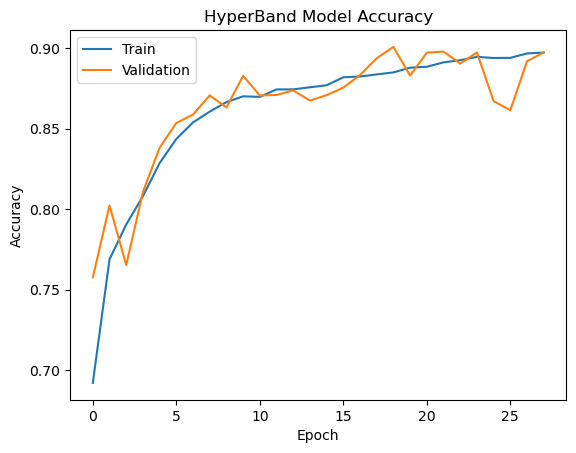

In [107]:
# train the best model using the hyper parameters found by the tuner to 150 epochs
hyper_model = build_model(best_hyper1, input_shape=input_shape)
hyper_history = hyper_model.fit(X1_train_scaled, y1_train, epochs=300, validation_data=(X1_val_scaled, y1_val), callbacks=[early_stopping, performance_threshold])
plt.plot(hyper_history.history['accuracy'])
plt.plot(hyper_history.history['val_accuracy'])
plt.title('HyperBand Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [112]:
# test the new model
model_loss, model_accuracy = hyper_model.evaluate(X1_test_scaled,y1_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8109/8109 - 12s - loss: 0.3010 - accuracy: 0.8969 - 12s/epoch - 2ms/step
Loss: 0.3010362684726715, Accuracy: 0.8968973755836487


In [113]:
# export the trained hyper model
hyper_model.save(f"Resources/phase1_best_model_3{model_accuracy}.h5")

Epoch 1/150
9460/9460 [==============================] - 47s 5ms/step - loss: 0.6422 - accuracy: 0.6789 - val_loss: 0.5714 - val_accuracy: 0.7367
Epoch 2/150
9460/9460 [==============================] - 45s 5ms/step - loss: 0.5819 - accuracy: 0.7234 - val_loss: 0.5739 - val_accuracy: 0.7306
Epoch 3/150
9460/9460 [==============================] - 45s 5ms/step - loss: 0.5693 - accuracy: 0.7390 - val_loss: 0.5379 - val_accuracy: 0.7712
Epoch 4/150
9460/9460 [==============================] - 45s 5ms/step - loss: 0.5593 - accuracy: 0.7498 - val_loss: 0.5279 - val_accuracy: 0.7751
Epoch 5/150
9460/9460 [==============================] - 45s 5ms/step - loss: 0.5545 - accuracy: 0.7570 - val_loss: 0.5527 - val_accuracy: 0.7674
Epoch 6/150
9460/9460 [==============================] - 45s 5ms/step - loss: 0.5616 - accuracy: 0.7535 - val_loss: 0.5237 - val_accuracy: 0.7796
Epoch 7/150
9460/9460 [==============================] - 45s 5ms/step - loss: 0.5487 - accuracy: 0.7640 - val_loss: 0.5420 -

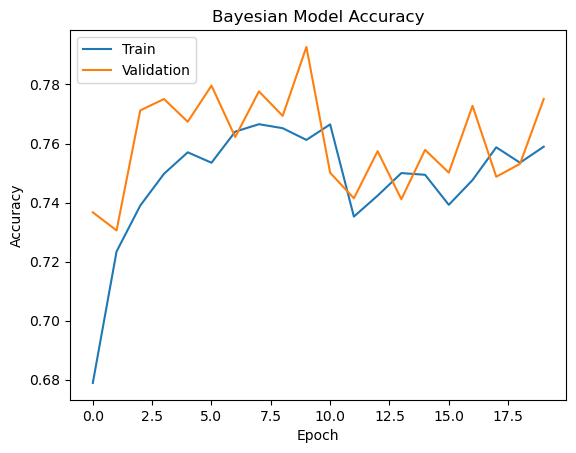

In [109]:
# train the best model using the hyper parameters found by the tuner to 150 epochs
bayesian_model = build_model(best_hyper2, input_shape=input_shape)
bayesian_history = bayesian_model.fit(X1_train_scaled, y1_train, epochs=150, validation_data=(X1_val_scaled, y1_val), callbacks=[early_stopping, performance_threshold])
plt.plot(bayesian_history.history['accuracy'])
plt.plot(bayesian_history.history['val_accuracy'])
plt.title('Bayesian Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [114]:
model_loss, model_accuracy = bayesian_model.evaluate(X1_test_scaled,y1_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8109/8109 - 14s - loss: 0.4942 - accuracy: 0.7762 - 14s/epoch - 2ms/step
Loss: 0.49422895908355713, Accuracy: 0.7761812806129456


In [115]:
# export the trained bayesian model
bayesian_model.save(f"Resources/phase1_best_model_4_{model_accuracy}.h5")

In [352]:
# predict slope on the production and add the predictions to a new dataframe for every model and average the predictions
production_base_predictions = production_base.copy()
# drop the year column
production_base_predictions.drop(columns='year', inplace=True)


# Usage of the prepare_data function
all_columns = set(production_base_predictions.columns)
categorical_columns = ['agency', 'Rank', 'year']  # Categorical columns
target_column1 = 'slope'  # or 'plus_1', based on which target you're working with
target_column2 = 'plus_1'
feature_columns = list(all_columns - set(categorical_columns) - {target_column1} - {target_column2})

def prepare_production_data (df, feature_columns):
    # Label encode 'year' if present
    if 'year' in df.columns:
        year_encoder = LabelEncoder()
        df['year'] = year_encoder.fit_transform(df['year'])

    # label encode rank and agency
    rank_encoder = LabelEncoder()
    df['Rank'] = rank_encoder.fit_transform(df['Rank'])
    agency_encoder = LabelEncoder()
    df['agency'] = agency_encoder.fit_transform(df['agency'])

    # Separate features and target
    X = df[feature_columns]

    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled

def transfer_prepare_production_data (df, feature_columns, target_column, test_size=0.2, random_state=0):
    # Label encode 'year' if present
    if 'year' in df.columns:
        year_encoder = LabelEncoder()
        df['year'] = year_encoder.fit_transform(df['year'])

    # label encode rank and agency
    rank_encoder = LabelEncoder()
    df['Rank'] = rank_encoder.fit_transform(df['Rank'])
    agency_encoder = LabelEncoder()
    df['agency'] = agency_encoder.fit_transform(df['agency'])

     # Separate features and target
    X = df[feature_columns]
    y = df[target_column]

    # Split the data into training and testing sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    return X_train_scaled, X_val_scaled, y_train, y_val


# Prepare the data for production model predictions
X_production_scaled = prepare_production_data(production_base_predictions, feature_columns)

In [353]:
production_y = production_base_predictions['slope']
print(production_y.shape)
# ensure the data type is ready for the model
production_y = production_y.astype('int')

(72,)


In [354]:
model_1 = load_model('Resources/hyper_model_0.89.h5')
model_2 = load_model('Resources/bayesian_model_0.77.h5')
model_3 = load_model('Resources/best_modelH_0.84.h5')
model_4 = load_model('Resources/best_modelB_0.78.h5')
model_5 = load_model('Resources/best_model_0.74.h5')

# create augmented data for transfer learning
augmented_production_base = augment_dataset_parallel(production_base_predictions, numerical_columns, copies_per_point=100, variance=0.05, n_jobs=-1)

# Prepare data for transfer learning
X_transfer_train_scaled, X_transfer_val_scaled, y_transfer_train, y_transfer_val = transfer_prepare_production_data(augmented_production_base, feature_columns, target_column1)

# ensure the data type is ready for the model
y_transfer_train = y_transfer_train.astype('int')
y_transfer_val = y_transfer_val.astype('int')

model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history1 = model_1.fit(X_transfer_train_scaled, y_transfer_train, epochs=300, validation_data=(X_transfer_val_scaled, y_transfer_val), callbacks=[early_stopping, performance_threshold])
history2 = model_2.fit(X_transfer_train_scaled, y_transfer_train, epochs=300, validation_data=(X_transfer_val_scaled, y_transfer_val), callbacks=[early_stopping, performance_threshold])
history3 = model_3.fit(X_transfer_train_scaled, y_transfer_train, epochs=300, validation_data=(X_transfer_val_scaled, y_transfer_val), callbacks=[early_stopping, performance_threshold])
history4 = model_4.fit(X_transfer_train_scaled, y_transfer_train, epochs=300, validation_data=(X_transfer_val_scaled, y_transfer_val), callbacks=[early_stopping, performance_threshold])
history5 = model_5.fit(X_transfer_train_scaled, y_transfer_train, epochs=300, validation_data=(X_transfer_val_scaled, y_transfer_val), callbacks=[early_stopping, performance_threshold])



Epoch 1/300
182/182 [==============================] - 3s 12ms/step - loss: 0.5042 - accuracy: 0.8192 - val_loss: 0.3137 - val_accuracy: 0.8845
Epoch 2/300
182/182 [==============================] - 2s 9ms/step - loss: 0.3016 - accuracy: 0.8900 - val_loss: 0.3158 - val_accuracy: 0.8722
Epoch 3/300
182/182 [==============================] - 1s 4ms/step - loss: 0.2845 - accuracy: 0.8920 - val_loss: 0.2758 - val_accuracy: 0.8935
Epoch 4/300
182/182 [==============================] - 1s 4ms/step - loss: 0.2833 - accuracy: 0.8869 - val_loss: 0.2889 - val_accuracy: 0.8749
Epoch 5/300
182/182 [==============================] - 1s 4ms/step - loss: 0.2666 - accuracy: 0.8963 - val_loss: 0.2880 - val_accuracy: 0.8646
Epoch 6/300
182/182 [==============================] - 1s 4ms/step - loss: 0.2659 - accuracy: 0.8929 - val_loss: 0.2710 - val_accuracy: 0.8804
Epoch 7/300
182/182 [==============================] - 1s 4ms/step - loss: 0.2650 - accuracy: 0.8967 - val_loss: 0.2820 - val_accuracy: 0.875

In [355]:
# print the accuracy of the model
model_loss, model_accuracy = model_1.evaluate(X_transfer_val_scaled,y_transfer_val,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")
# round the accuracy to 2 decimal places
model_accuracy = round(model_accuracy, 2)
# save all models to a file for the year 2022
model_1.save(f"Resources/phase1_model_6_TL_2022_{model_accuracy}.h5")

# print the accuracy of the model
model_loss, model_accuracy = model_2.evaluate(X_transfer_val_scaled,y_transfer_val,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

# round the accuracy to 2 decimal places
model_accuracy = round(model_accuracy, 2)

# save all models to a file for the year 2022
model_2.save(f"Resources/phase1_model_7_TL_2022_{model_accuracy}.h5")

# print the accuracy of the model
model_loss, model_accuracy = model_3.evaluate(X_transfer_val_scaled,y_transfer_val,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

# round the accuracy to 2 decimal places
model_accuracy = round(model_accuracy, 2)

# save all models to a file for the year 2022
model_3.save(f"Resources/phase1_model_8_TL_2022_{model_accuracy}.h5")

# print the accuracy of the model
model_loss, model_accuracy = model_4.evaluate(X_transfer_val_scaled,y_transfer_val,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

# round the accuracy to 2 decimal places
model_accuracy = round(model_accuracy, 2)

# save all models to a file for the year 2022
model_4.save(f"Resources/phase1_model_9_TL_2022_{model_accuracy}.h5")

# print the accuracy of the model
model_loss, model_accuracy = model_5.evaluate(X_transfer_val_scaled,y_transfer_val,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

# round the accuracy to 2 decimal places
model_accuracy = round(model_accuracy, 2)

# save all models to a file for the year 2022
model_5.save(f"Resources/phase1_model_10_TL_2022_{model_accuracy}.h5")


46/46 - 0s - loss: 0.2882 - accuracy: 0.8584 - 232ms/epoch - 5ms/step
Loss: 0.28820139169692993, Accuracy: 0.8584192395210266
46/46 - 0s - loss: 0.5137 - accuracy: 0.8158 - 318ms/epoch - 7ms/step
Loss: 0.5136867165565491, Accuracy: 0.815807580947876
46/46 - 0s - loss: 0.2574 - accuracy: 0.8962 - 273ms/epoch - 6ms/step
Loss: 0.25744715332984924, Accuracy: 0.8962199091911316
46/46 - 0s - loss: 0.4840 - accuracy: 0.7918 - 301ms/epoch - 7ms/step
Loss: 0.48397839069366455, Accuracy: 0.7917525768280029
46/46 - 0s - loss: 0.2124 - accuracy: 0.8811 - 188ms/epoch - 4ms/step
Loss: 0.21236059069633484, Accuracy: 0.8810996413230896


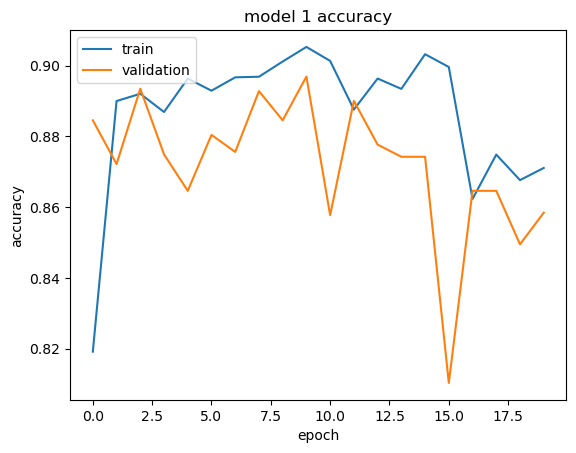

In [356]:
#plot the accuracy of the model
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model 1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

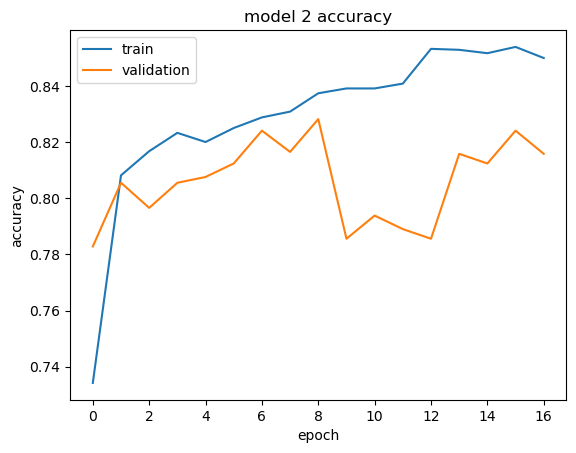

In [358]:
#plot the accuracy of the model
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model 2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

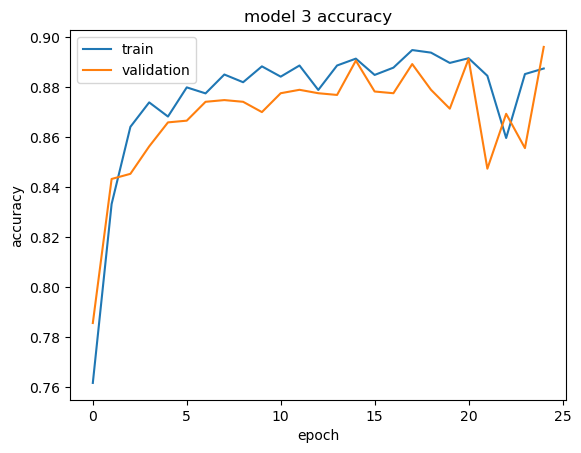

In [359]:
#plot the accuracy of the model
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model 3 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

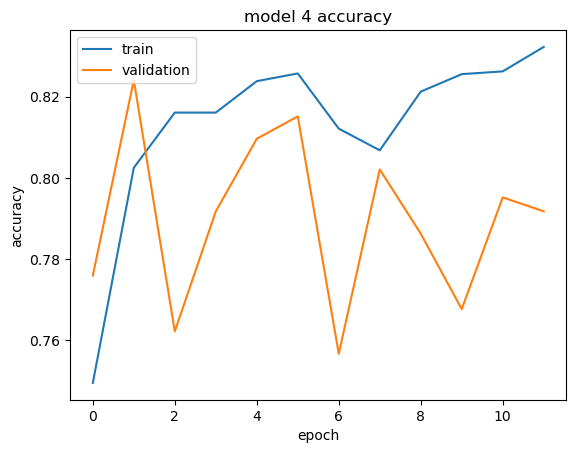

In [360]:
#plot the accuracy of the model
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model 4 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

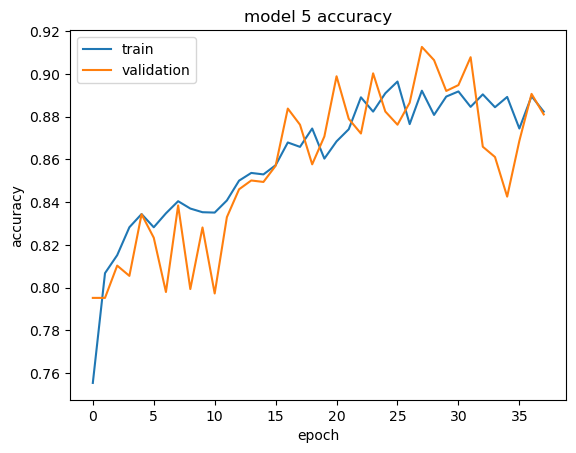

In [361]:
#plot the accuracy of the model
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('model 5 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

In [362]:
# load the models for the year 2022 as model 6, 7, 8, 9, and 10
model_6 = load_model('Resources/model_1_TL_2022_0.86.h5')
model_7 = load_model('Resources/model_2_TL_2022_0.82.h5')
model_8 = load_model('Resources/model_3_TL_2022_0.9.h5')
model_9 = load_model('Resources/model_4_TL_2022_0.79.h5')
model_10 = load_model('Resources/model_5_TL_2022_0.88.h5')

In [363]:


# result base
result_base_predictions = end_strength[end_strength['year'] == 2022].copy()

# result_base_predictions['model_1'] = model_1.predict(X_production_scaled).round()
# result_base_predictions['model_2'] = model_2.predict(X_production_scaled).round()
# result_base_predictions['model_3'] = model_3.predict(X_production_scaled).round()
# result_base_predictions['model_4'] = model_4.predict(X_production_scaled).round()
# result_base_predictions['model_5'] = model_5.predict(X_production_scaled).round()
result_base_predictions['model_6'] = model_6.predict(X_production_scaled).round()
result_base_predictions['model_7'] = model_7.predict(X_production_scaled).round()
result_base_predictions['model_8'] = model_8.predict(X_production_scaled).round()
result_base_predictions['model_9'] = model_9.predict(X_production_scaled).round()
result_base_predictions['model_10'] = model_10.predict(X_production_scaled).round()

#create a list of models
models = [ 'model_6', 'model_7', 'model_8', 'model_9', 'model_10']

result_base_predictions['average_slope'] = result_base_predictions[models].mean(axis=1)
# export the production base predictions to a csv
result_base_predictions.to_csv('Resources/result_base_predictions.csv', index=False)
print(result_base_predictions.head(100))

3/3 [==============================] - 0s 4ms/step
     year agency Rank minus_2 minus_1 current plus_1 slope  model_6  model_7  \
288  2022     AR  O10      -1       0      16     -1     0      0.0      0.0   
289  2022     AR   O9      -1      -2      46     -2     0      0.0      0.0   
290  2022     AR   O8      15       3     108    -13     0      0.0      0.0   
291  2022     AR   O7     -20     -11     118     -5     0      0.0      0.0   
292  2022     AR   O6    -235    -136    3767   -113     0      0.0      0.0   
..    ...    ...  ...     ...     ...     ...    ...   ...      ...      ...   
931  2022     AF   E5   -1095   -1189   60411  -4286     0      0.0      0.0   
932  2022     AF   E4    4393     791   61854   2956     1      1.0      1.0   
933  2022     AF   E3   -7323   -2283   46138  -1648     0      0.0      0.0   
934  2022     AF   E2     136    -111    8032   -318     0      0.0      0.0   
935  2022     AF   E1     734     606    8872   -646     0      0.0  

In [365]:
#model 6
model_6_predictions = model_6.predict(X_production_scaled)
model_6_predictions = np.round(model_6_predictions)

confusion_matrix_6 = confusion_matrix(production_y, model_6_predictions)
print("model 6")
print(confusion_matrix_6)



# model 7
model_7_predictions = model_7.predict(X_production_scaled)
model_7_predictions = np.round(model_7_predictions)


confusion_matrix_7 = confusion_matrix(production_y, model_7_predictions)
print("model 7")
print(confusion_matrix_7)

# model 8
model_8_predictions = model_8.predict(X_production_scaled)
model_8_predictions = np.round(model_8_predictions)

confusion_matrix_8 = confusion_matrix(production_y, model_8_predictions)
print("model 8")
print(confusion_matrix_8)


# model 9
model_9_predictions = model_9.predict(X_production_scaled)
model_9_predictions = np.round(model_9_predictions)


confusion_matrix_9 = confusion_matrix(production_y, model_9_predictions)
print("model 9")
print(confusion_matrix_9)

# model 10
model_10_predictions = model_10.predict(X_production_scaled)
model_10_predictions = np.round(model_10_predictions)


confusion_matrix_10 = confusion_matrix(production_y, model_10_predictions)
print("model 10")
print(confusion_matrix_10)

# create a confusion matrix for the average slope
average_slope_predictions = result_base_predictions['average_slope']
average_slope_predictions = np.round(average_slope_predictions)

confusion_matrix_average = confusion_matrix(production_y, average_slope_predictions)
print("average slope")
print(confusion_matrix_average)



3/3 [==============================] - 0s 3ms/step
model 6
[[54  0]
 [ 9  9]]
3/3 [==============================] - 0s 7ms/step
model 7
[[52  2]
 [10  8]]
3/3 [==============================] - 0s 7ms/step
model 8
[[50  4]
 [ 3 15]]
3/3 [==============================] - 0s 6ms/step
model 9
[[53  1]
 [13  5]]
3/3 [==============================] - 0s 5ms/step
model 10
[[54  0]
 [ 8 10]]
average slope
[[54  0]
 [ 9  9]]


In [385]:
# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_mean_squared_error',  # Monitor validation MSE
    min_delta=0.001,                   # Minimum change to qualify as an improvement
    patience=10,                       # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    mode='min'                         # 'min' for regression metrics like MSE
)

# Custom Callback for Regression Metric Threshold
class RegressionMetricThresholdCallback(Callback):
    def __init__(self, threshold):
        super(RegressionMetricThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        metric = logs.get("val_mean_squared_error")  # Adjust based on your chosen metric
        if metric is not None:
            if metric <= self.threshold:
                print(f"\nReached MSE lower than {self.threshold}, stopping training!")
                self.model.stop_training = True

# Instantiate the callback with your desired threshold for MSE
regression_metric_threshold = RegressionMetricThresholdCallback(threshold=0.05)

# Model Checkpoint for Hyperparameter Tuning Model
checkpoint_hyper = ModelCheckpoint(
    "checkpoints/PH2hyper_weights.{epoch:02d}.hdf5",
    monitor="val_mean_squared_error",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    save_freq="epoch",
    options=None
)

# Model Checkpoint for Bayesian Optimization Model
checkpoint_bayesian = ModelCheckpoint(
    "checkpoints/PH2bayesian_weights.{epoch:02d}.hdf5",
    monitor="val_mean_squared_error",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    save_freq="epoch",
    options=None
)


In [386]:
# create test set for training set 2
categorical_columns = ['agency', 'Rank', 'year']
# Usage of the prepare_data function
all_columns = set(training_base.columns)
categorical_columns = ['agency', 'Rank', 'year']  # Categorical columns
target_column1 = 'slope'  # or 'plus_1', based on which target you're working with
target_column2 = 'plus_1'
feature_columns = list(all_columns - set(categorical_columns) - {target_column1} - {target_column2})
numerical_columns = list(all_columns - set(categorical_columns) - {target_column1})


# drop year

training_set_2.head()

,agency,Rank,minus_2,minus_1,current,plus_1,slope,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4
0,1,10,0.000000,1.000000,12.000000,0.000000,1,9241.000000,8651.000000,0.000000,0.000000,1521.000000
0,1,10,0.033271,0.981638,11.965952,0.048765,1,9240.879300,8651.180254,-0.050827,0.136127,1521.064281
0,1,10,-0.100598,1.177120,11.996417,0.177117,1,9240.932926,8650.952758,0.122956,-0.036874,1521.046331
0,1,10,-0.165798,1.003308,12.136192,0.090945,1,9240.972066,8650.963737,-0.112547,0.228052,1520.926566
0,1,10,-0.058588,0.825792,11.970514,0.041944,1,9240.920581,8651.018552,-0.166935,0.005072,1521.008601


In [387]:
print(training_set_2.shape)

(864864, 12)


In [388]:
clear_project_dir('tuner2')
clear_project_dir('tuner3')

In [389]:
def prepare_data_linear(df, target_column, feature_columns, test_size=0.3, random_state=0):
    # Label encode 'year' if present
    if 'year' in df.columns:
        year_encoder = LabelEncoder()
        df['year'] = year_encoder.fit_transform(df['year'])

    # label encode rank and agency
    rank_encoder = LabelEncoder()
    df['Rank'] = rank_encoder.fit_transform(df['Rank'])
    agency_encoder = LabelEncoder()
    df['agency'] = agency_encoder.fit_transform(df['agency'])



    # Separate features and target
    X = df[feature_columns]
    y = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=random_state)

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # scale the target
    scaler2 = StandardScaler()
    y_train_scaled = scaler2.fit_transform(y_train.values.reshape(-1,1))
    y_val_scaled = scaler2.transform(y_val.values.reshape(-1,1))
    y_test_scaled = scaler2.transform(y_test.values.reshape(-1,1))

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train_scaled, y_val_scaled, y_test_scaled

# Prepare the data for training set 2
X2_train_scaled, X2_val_scaled, X2_test_scaled, y2_train_scaled, y2_val_scaled, y2_test_scaled = prepare_data_linear(
    training_set_2, target_column2, feature_columns)


#y2_train = y2_train.astype('int')
#y2_val = y2_val.astype('int')
#y2_test = y2_test.astype('int')



# Print shapes to verify
print("Training set 2 shape: ", X2_train_scaled.shape, y2_train_scaled.shape)


input_shape = X1_train_scaled.shape[1:]

# Create a method that creates a new Sequential model with hyperparameter options
def build_model_MSE(hp, input_shape):

    # Initialize the Sequential model
    model = tf.keras.Sequential()


    model.add(layers.Dense(units=hp.Int('units', min_value=1, max_value=500, step=10), activation='relu', input_shape=input_shape, kernel_regularizer=tf.keras.regularizers.l1(0.001)))

    # Tuning the number of units in the first Dense layer
    hp_units = hp.Int('units', min_value=1, max_value=500, step=10)
    

    model.add(layers.Dense(units=hp_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))

    model.add(layers.Dense(units=hp_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.001)))

    # Tuning the dropout rate
    hp_dropout = hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.25, step=0.05)
    model.add(layers.Dropout(rate=hp_dropout))

    # Adding additional hidden layers
    for i in range(hp.Int('num_layers', 1, 50)):
        # Each hidden layer can have its own number of units and dropout rate
        layer_units = hp.Int(f'units_{i}', min_value=1, max_value=200, step=5)
        model.add(layers.Dense(units=layer_units, activation=hp.Choice(f'activation_{i}', values=['relu', 'tanh'])))
        

    # Output layer
    model.add(layers.Dense(units=1, activation='linear'))


    model.compile(optimizer='adam',
                  loss='mean_squared_error', 
                  metrics=[
                      'mean_squared_error',  # MSE
                      MeanAbsoluteError(name='mae'),  # MAE
                      RootMeanSquaredError(name='rmse'),  # RMSE
                      'mean_squared_logarithmic_error'  # MSLE
                  ])
    return model

# Initialize the tuner
tuner3 = kt.Hyperband(
    lambda hp: build_model_MSE(hp, input_shape=input_shape),
    objective='val_mean_squared_error',
    max_epochs=25,
    project_name='tuner2',
    hyperband_iterations=1
)


tuner4 = BayesianOptimization(
    lambda hp: build_model_MSE(hp, input_shape=input_shape),
    objective='val_mean_squared_error',
    max_trials=5,
    executions_per_trial=3,
    project_name='tuner3'
)

Training set 2 shape:  (302702, 8) (302702, 1)


In [390]:
# search

tuner3.search(X2_train_scaled, y2_train_scaled, 
             epochs=300,
             validation_data=(X2_val_scaled, y2_val_scaled),
             callbacks=[early_stopping, regression_metric_threshold, checkpoint_hyper]
             )


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
211               |211               |units
0                 |0                 |dropout
18                |18                |num_layers
51                |51                |units_0
relu              |relu              |activation_0
3                 |3                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/3
9459/9460 [============================>.] - ETA: 0s - loss: 1.0275 - mean_squared_error: 1.0000 - mae: 0.4576 - rmse: 1.0000 - mean_squared_logarithmic_error: 0.0963
Epoch 1: val_mean_squared_error improved from inf to 1.00531, saving model to checkpoints\PH2hyper_weights.01.hdf5
9460/9460 [==============================] - 176s 18ms/step - loss: 1.0275 - mean_squared_error: 1.0001 - mae: 0.4576 - rmse: 1.0000 - mean_squared_logarithmic_error: 0.0963 - val_

KeyboardInterrupt: 

In [ ]:
# Get the best model from the tuner
phase2_best_modelH = tuner4.get_best_models()[0]

# Evaluate the model on the test set
evaluation_results = phase2_best_modelH.evaluate(X2_test_scaled, y2_test_scaled)
# RMSE is at index 3
rmse_value = evaluation_results[3]

# Determine how to format the RMSE value for the filename
rmse_label = round(rmse_value) if rmse_value >= 1 else round(rmse_value * 100)

# Save the model with RMSE in the filename
phase2_best_modelH.save(f"Resources/phase2_best_model_1_RMSE_{rmse_label}.h5")

In [ ]:
# search

tuner4.search(X2_train_scaled, y2_train_scaled,
                epochs=300,
                validation_data=(X2_val_scaled, y2_val_scaled),
                callbacks=[early_stopping, regression_metric_threshold, checkpoint_bayesian]
                )

In [ ]:
# Get the best model from the tuner
phase2_best_modelB = tuner4.get_best_models()[0]

# Evaluate the model on the test set
evaluation_results = phase2_best_modelB.evaluate(X2_test_scaled, y2_test_scaled)
# RMSE is at index 3
rmse_value = evaluation_results[3]

# Determine how to format the RMSE value for the filename
rmse_label = round(rmse_value) if rmse_value >= 1 else round(rmse_value * 100)

# Save the model with RMSE in the filename
phase2_best_modelB.save(f"Resources/phase2_best_model_2_RMSE_{rmse_label}.h5")


In [ ]:
# Get top 3 model hyperparameters and print the values
print("TUNER 3")
top_hyper3 = tuner3.get_best_hyperparameters(3)
for param in top_hyper3:
    print(param.values)

print("TUNER 4")

top_hyper4 = tuner4.get_best_hyperparameters(3)
for param in top_hyper4:
    print(param.values)



In [ ]:
# Get best model hyperparameters
best_hyper3 = tuner3.get_best_hyperparameters(1)[0]
print(f" Hyperband values: {best_hyper3.values}")

best_hyper4 = tuner4.get_best_hyperparameters(1)[0]
print(f"Bayesian values: {best_hyper4.values}")


In [ ]:
# Evaluate the top 3 models against the test dataset
top_model_3 = tuner3.get_best_models(3)
print("Hyperband:")
for model in top_model_3:
    model_mse, model_rmse = model.evaluate(X2_test_scaled,y2_test_scaled,verbose=2)
    # Print the MSE and RMSE
    print(f"MSE: {model_mse}, RMSE: {model_rmse}")

top_model_4 = tuner4.get_best_models(3)
print("Bayesian:")
for model in top_model_4:
    model_mse, model_rmse = model.evaluate(X2_test_scaled,y2_test_scaled,verbose=2)
    # Print the MSE and RMSE
    print(f"MSE: {model_mse}, RMSE: {model_rmse}")



In [ ]:
# train the best model using the hyper parameters found by the tuner to 150 epochs
hyper_model3 = build_model(best_hyper3, input_shape=input_shape)
hyper_history3 = hyper_model3.fit(X2_train_scaled, y2_train_scaled, epochs=300, validation_data=(X2_val_scaled, y2_val_scaled), callbacks=[early_stopping, regression_metric_threshold])
plt.plot(hyper_history3.history['mean_squared_error'])
plt.plot(hyper_history3.history['val_mean_squared_error'])
plt.title('HyperBand Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model on the test set
model_mse, _, _, model_rmse, _ = hyper_model3.evaluate(X2_test_scaled, y2_test_scaled, verbose=2)

# Print the MSE and RMSE
print(f"MSE: {model_mse}, RMSE: {model_rmse}")

# Use RMSE for the filename, rounding if necessary
rmse_label = round(model_rmse) if model_rmse >= 1 else round(model_rmse * 100)

# Save the model with RMSE in the filename
hyper_model3.save(f"Resources/phase2_best_model_3_RMSE_{rmse_label}.h5")


In [ ]:
# train the best model using the hyper parameters found by the tuner to 150 epochs
bayesian_model4 = build_model(best_hyper4, input_shape=input_shape)
bayesian_history4 = bayesian_model4.fit(X2_train_scaled, y2_train_scaled, epochs=300, validation_data=(X2_val_scaled, y2_val_scaled), callbacks=[early_stopping, regression_metric_threshold])
plt.plot(bayesian_history4.history['mean_squared_error'])
plt.plot(bayesian_history4.history['val_mean_squared_error'])
plt.title('Bayesian Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model on the test set
model_mse, _, _, model_rmse, _ = bayesian_model4.evaluate(X2_test_scaled, y2_test_scaled, verbose=2)

# Print the MSE and RMSE
print(f"MSE: {model_mse}, RMSE: {model_rmse}")

# Use RMSE for the filename, rounding if necessary
rmse_label = round(model_rmse) if model_rmse >= 1 else round(model_rmse * 100)

# Save the model with RMSE in the filename
bayesian_model4.save(f"Resources/phase2_best_model_4_RMSE_{rmse_label}.h5")

In [ ]:
# # Predict using the model
# predictions_scaled = model.predict(X_test_scaled)
# scaler = StandardScaler()
# # Inverse transform to get predictions in original scale
# predictions_original = scaler.inverse_transform(predictions_scaled)